#### Data 620 - Project 2 <br>June 26, 2019<br>Team 2: <ul><li>Anthony Munoz</li> <li>Katie Evers</li> <li>Juliann McEachern</li> <li>Mia Siracusa</li></ul>

<h1 align="center">Network Analysis: 2-Mode Networks</h1>

<h2 style="color:#088A68;">Project Overview</h2>

We will be examining datasets from a Nowegian [Boards and Gender](http://www.boardsandgender.com/data.php) study. The purpose of the study was to evaluate the effect gender representation laws had on the gender composition of companies' Board of Directors within Norway.

We choose to look at their 2-Mode Network from July 2011. We first examined the network using a bipartite approach. Then, we  implored the island method from our Social Network Analysis text to see if we could derive any significant conclusions about our network. Our results are outlined in our conclusion section.

<h2 style="color:#088A68;">Getting Started: 2-Mode Network</h2>

In a 2-Mode network, "there are two different types of nodes and links determine relationships between one set of nodes and the other." (Tsvetovat & Kouznetsov 96). In the following steps, we loaded our python dependencies and combined our datasets using pandas transformations.

We will be examining the connection between 95 directors and 100 corporate boards of which they serve. Both factors were treated as distinct groups. We will retain the gender feature for directors and use this feature when examining our graph later on. 

#### Python Dependencies 

In [1]:
import pandas as pd, networkx as nx,matplotlib.pyplot as plt, numpy as np, warnings, seaborn as sns 
from networkx.algorithms import bipartite
import psy
warnings.filterwarnings('ignore') 

#### Load & Transform Network Data

Data was loaded and merged into a pandas dataframe. Unused columns were dropped and some column were renamed for better understanding of our dataset. We are interested in eventually looking at gender representation among board of directors, thus we set our edge weights attribute to the frequency of board occurances in our network. This will help us view the gender composition of our key directors later on. 

In [2]:
#affiliation of directors to organizational boards
net2m = pd.read_csv('http://www.boardsandgender.com/data/net2m/net2m_2011-07-01.txt', sep=" ", header=None)
net2m.columns=["director", "board"]
#company attributes
comp = pd.read_csv('https://raw.githubusercontent.com/jemceach/620/master/Project-2/companies.csv', header=None)
comp.columns=["id", "org_no","org_name","postcode_city"]; comp=comp.drop(["org_no","postcode_city"], axis=1)
#people attributes
ppl = pd.read_csv('https://raw.githubusercontent.com/jemceach/620/master/Project-2/peoples.csv',encoding = "ISO-8859-1")
ppl['gender'] = ppl['gender'].replace(1, "M").replace(2, "F")
#merge datasets
net2m=net2m.merge(ppl, left_on='director', right_on='id').drop("id",axis=1).merge(comp, left_on='board', right_on='id').drop("id",axis=1)
net2m=net2m.astype('category')
#created weight from the frequency of occurance
net2m['weight'] = net2m.groupby('board')['board'].transform('count') 
#preview data
net2m.head()

,director,board,name,gender,org_name,weight
0,3,88,Aage Rasmus Bjelland Figenschou,M,CONTRACT CO BETA ASA,1
1,5,207,Aase Gundersen,F,NEXTCOM HOLDING ASA,1
2,7,313,Aasmund Frøseth,M,SKEI MARINFISK ASA,1
3,11,64,Adine Charlotte Grate Axen,F,BYGD&Oslash; ALL&Eacute; FINANSSENTER ASA,1
4,15,253,Åge Andersen,M,PARETO ENERGY SOLUTIONS INVESTOR ASA,1


<h2 style="color:#088A68;">Biparthite Graph</h2>

We choose to first examine our network as a biparthite graph. The biparthite layout decomposed graph vertices into two disjoint sets for us to evalutate. In a biparthite network, in the same biparthite are note meant to ever connect with one another (ie two corporation will never be linked).

#### Build Network

We built our network by looping through our dataset to add 2 sets of bipartite nodes. These nodes were added with the node attribute set to "bipartite". Edges were added only between nodes of opposite bipartite node sets. The weight of each node was projected using the Jaccard method, which creates an index number using neighborhood calculations between two nodes from the original bipartite network.  

In [3]:
B = nx.Graph()

for i in range(len(net2m)): 
    B.add_node(net2m.iloc[i][0], bipartite=0, gender=net2m.iloc[i][3]) # set directors to bipartite 0
    B.add_node(net2m.iloc[i][4], bipartite=1, board=net2m.iloc[i][1]) # set org_name to bipartite 1
    B.add_edge(net2m.iloc[i][0], net2m.iloc[i][4], weight=net2m.iloc[i][5]) # add edges 

# identify top and bottom nodes
top_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
bottom_nodes = set(B) - top_nodes

# verification
print("Verify graph is_bipartite:",nx.is_bipartite(B))

Verify graph is_bipartite: True


#### Biparthite Network Evaluation

Our average clustering metric represents a general clustering coefficient for all network vertices. An average of 1 would indicate that our network was completely connected, whereas 0 would mean our graph has no closed connections. Our low output shows that there a few triangular connections that exist between board of directors and the boards which they serve. 

The biadjacency matrix, visualized with the heatmap below, represents node adjacency between our distinct node groups. The map is sparce for two reasons. First, with biparthite networks, our two verticies are not connect with members within the same group. We also expected this particular network to be sparse as few individuals serve as board of directors for multiple companies within our datasubset. Similiarly, we expect each companies to consist of only a few board of directors at most.

Average clustering: 0.2866096866096866


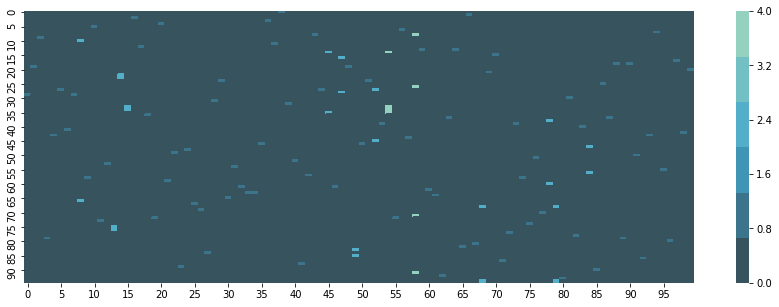

In [4]:
print("Average clustering:", bipartite.cluster.average_clustering(B))

plt.figure(figsize=(15,5))
matrix=bipartite.matrix.biadjacency_matrix(B, top_nodes).todense()
sns.heatmap(matrix,xticklabels=5,yticklabels=5, cmap=sns.color_palette('GnBu_d'))
plt.show()

#### Examine Network

The output below highlights some basic features of our network.

In [5]:
print("\nNetwork",nx.info(B))


Network Name: 
Type: Graph
Number of nodes: 195
Number of edges: 118
Average degree:   1.2103


#### Visualize Network

The bipartite layout below helps visualize our connections by positioning our nodes in two straight lines. This graph shows us the connections between director and their board affiliation.

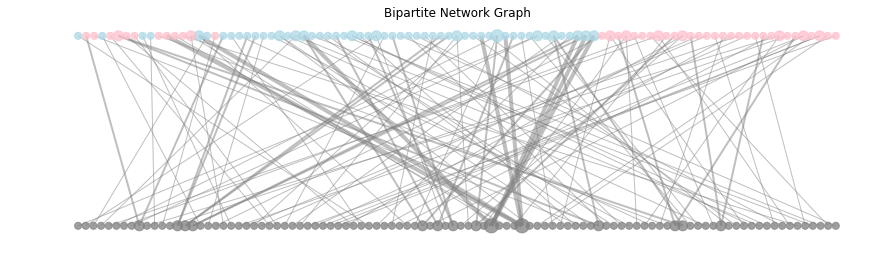

In [6]:
plt.figure(figsize=(15, 4))
           
# set layout position
pos=nx.bipartite_layout(B,top_nodes, align='horizontal') 


# Set node color based on gender
male = set(net2m[net2m['gender']=="M"].iloc[:, 0].unique())
female = set(net2m[net2m['gender']=="F"].iloc[:, 0].unique())

nodecolors=[]
for n in dict(B.degree()).keys():
    if n in male:
        nodecolors.append('lightblue')
    elif n in female:
        nodecolors.append('pink')
    else:
        nodecolors.append('grey')

# nodes
d = B.degree()
nx.draw_networkx_nodes(B,pos, node_color=nodecolors, node_size=[v*50 for v in dict(d).values()], alpha=0.75)

# edges drawn with widths set to edge weight
nx.draw_networkx_edges(B,pos,alpha=0.5,width=[c for (u, v, c) in B.edges.data('weight')],edge_color='grey',style='solid')

plt.axis('off')
plt.title('Bipartite Network Graph')
plt.show()

## Network Reduction

#### Island Method
The island method is a way to split up a large data set into smaller sections with more activity. These smaller sections can then be analyzed individually. Essentially, the large component is "flooded" and the valleys, or the areas data sets with the least edges, are submerged into water. The water, essentially a threshold on the edge values, thus breaks the large component into smaller pieces, or "islands".

We explored this technique using the island method as described in chapter 4 of our Social Network Analysis text.

In [7]:
## Implementing the Island Method to look for important subgroups. 
def trim_edges(b, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    b2 = nx.Graph()
    for u, v, c in B.edges(data=True):
        if c['weight'] > weight:
            b2.add_edge(u,v, weight=c)
    return b2

## Return list of graphs each corresponding to different thresholds
def island_method(B, iterations=3):
    weights= [c for (u, v, c) in B.edges.data('weight')]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of step
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(B, threshold)] for threshold in range(mn,mx,step)]

#### Island Output

By calling the `island_method` function below, we trim our edges to exclude singular node connections and identify smaller subsections with our network. We were able to iterate through our network three times because our maximum degree weight was 4. 

At our first threshold, we found 11 islands consisting of 40 nodes. Our second and third iterations both revealed 10 nodes on 2 islands. Through additional analysis, we uncovered the reason behind this result was that none of our corporate boards have only 3 connections. 

In [8]:
#ignored nx.connected_component_subgraphs component. Network has max 4 connections. No need to isolate the biggest component.
island = island_method(B, iterations = 3)

#print the threshold level, size of the graph, and number of connected components
for i in island:
    print("Threshold:",i[0], "Size:",len(i[1]), "Connections:", len(list(nx.connected_component_subgraphs(i[1]))))

Threshold: 1 Size: 40 Connections: 11
Threshold: 2 Size: 10 Connections: 2
Threshold: 3 Size: 10 Connections: 2


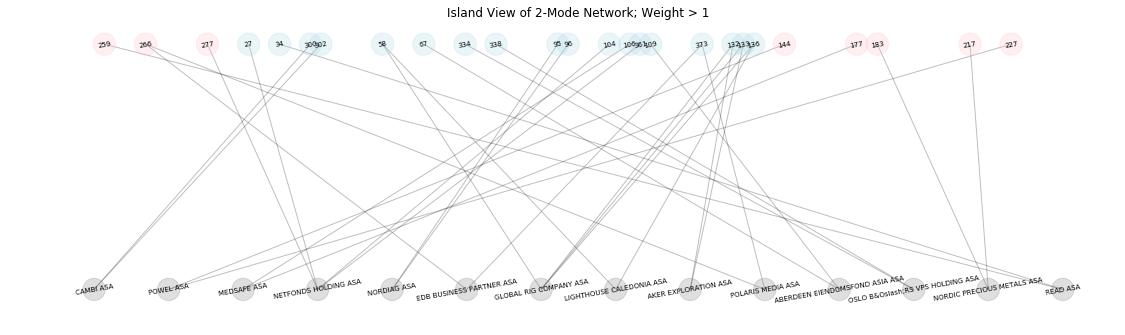

In [9]:
plt.figure(figsize=(15, 4))

# Apply island method
B1=trim_edges(B,weight=1)

# set layout position
pos=nx.bipartite_layout(B1,top_nodes, align='horizontal') 

# Set node color based on gender
male = set(net2m[net2m['gender']=="M"].iloc[:, 0].unique())
female = set(net2m[net2m['gender']=="F"].iloc[:, 0].unique())

nodecolors=[]
for n in dict(B1.degree()).keys():
    if n in male:
        nodecolors.append('lightblue')
    elif n in female:
        nodecolors.append('pink')
    else:
        nodecolors.append('grey')

nx.draw(B1, pos, node_size=500, alpha=.25, node_color=nodecolors)

text = nx.draw_networkx_labels(B1,pos, font_size=7)

for _,t in text.items():
    t.set_rotation('10')
    
plt.axis('off')
plt.title('Island View of 2-Mode Network; Weight > 1')
plt.tight_layout()

Our final trim helps us visualize our organizations with the most corporate boards with the largest composition of directors.

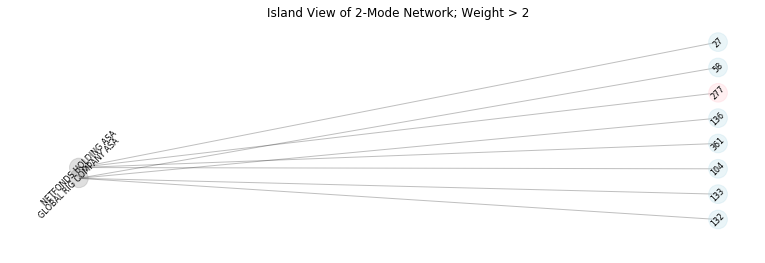

In [10]:
plt.figure(figsize=(10, 3))

# Apply island method
B2=trim_edges(B,weight=2)

# set layout position
pos=nx.bipartite_layout(B2,bottom_nodes, align='vertical') 

# Set node color based on gender
male = set(net2m[net2m['gender']=="M"].iloc[:, 0].unique())
female = set(net2m[net2m['gender']=="F"].iloc[:, 0].unique())

nodecolors=[]
for n in dict(B2.degree()).keys():
    if n in male:
        nodecolors.append('lightblue')
    elif n in female:
        nodecolors.append('pink')
    else:
        nodecolors.append('grey')

nx.draw(B2, pos, node_size=350, alpha=.25,node_color=nodecolors)

text = nx.draw_networkx_labels(B2,pos, font_size=8)

for _,t in text.items():
    t.set_rotation('45')
    
plt.axis('off')
plt.title('Island View of 2-Mode Network; Weight > 2')
plt.tight_layout()

## Analysis 

Our initial bipartite graph showed us the general composition of our 2-network graph. By reducing our edges, we were able to come to a more meaningful, visual conclusion about the connections in our network. The results of which are verified in the pivot table at the end of the report. 

The data from which our study was taken from was designed to analyze the effect Norwegian gender representation law had on the number of women board members over time. We selected to solely look at the month of July 2011. In this month, men consisted of 57% of our raw data. Once we trimmed our network, our first island revealed that the male composition of boards increased to 72% when boards consisted of more than 1 director. This number rose again upon our final trim. Our second island consisted of two boards with four degrees that was 87.5% male. 

As of the 2011 study, there were 384 public limited companies in Norway. Our subset of data only contained 100 of those companies. It would be interesting to reevaluate our board and director network in the context of this study using more months to see how our proportions changed over time. 

In [11]:
subset=net2m.drop(['weight', 'name'], axis=1)
subset['board_freq']=net2m.groupby(['board', 'org_name'], as_index='org_name')['board'].transform('count') 
subset=subset.groupby(['org_name','gender','board_freq'], as_index='org_name').nunique()[['director']]
subset=subset.sort_values('board_freq',ascending=False)
subset=subset.reset_index('board_freq').drop('board_freq',axis=1)
subset.head(19)

director
org_name                         gender          
NETFONDS HOLDING ASA             M              3
                                 F              1
GLOBAL RIG COMPANY ASA           M              4
ABERDEEN EIENDOMSFOND ASIA ASA   M              2
CAMBI ASA                        M              2
MEDSAFE ASA                      M              1
                                 F              1
NORDIC PRECIOUS METALS ASA       F              2
LIGHTHOUSE CALEDONIA ASA         M              2
OSLO B&Oslash;RS VPS HOLDING ASA M              2
EDB BUSINESS PARTNER ASA         M              1
                                 F              1
POLARIS MEDIA ASA                M              1
POWEL ASA                        F              2
READ ASA                         F              1
                                 M              1
POLARIS MEDIA ASA                F              1
NORDIAG ASA                      M              2
AKER EXPLORATION ASA             M              2

---
#### References

1. Social Network Analysis for Startups, Maksim Tsvetovat and Alexander Kouznetsov, O'Reilly, Sep 30, 201
2. Seierstad, C., Opsahl, T. (2011). For the few not the many? The effects of affirmative action on presence, prominence, and social capital of female directors in Norway. Scandinavian Journal of Management 27 (1), 44-54, doi: 10.1016/j.scaman.2010.10.002; 
3. NetworkX Bipartite Algorithm. Retrieved from https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html 
4. Clustering Coefficient in Graph Theory. (2018, February 08). Retrieved from https://www.geeksforgeeks.org/clustering-coefficient-graph-theory/ 